National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Introduction to Deep Learning

Final Project: Natural Language Processing (Part 2)

Student: Andrei Batyrov (Fall2022)

Date: 3-Dec-2023

##### Table of Contents

[Description](#description)

[Part 2: Natural Language Processing](#nlp)

1. [Data Analysis](#data-analysis)

2. [RuBERT](#rubert)

3. [mBERT on RuCoLa](#mbert-1)

4. [mBERT on RuCoLa + CoLa](#mbert-2)

5. [Summary](#summary)




In [60]:
# Essential import
import gc
import json
from collections import Counter
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, matthews_corrcoef
from tqdm import tqdm
import matplotlib.pyplot as plt
epochs = 10 # Number of epochs to train
seed = 13
batch_size = 384 # Train on this many images per batch
torch.manual_seed(seed=seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device = }')

device = device(type='cuda')


Some helper functions.

In [2]:
def plot_bar(df, x, y, xlabel, title, kind='vertical', bar_label=False, ylim=None, rot=0, err=None):
    '''
    Plot bar plot, where `x` and `y` are column names of Pandas Dataframe `df`.
    '''
    if kind not in ('vertical', 'horizontal'):
        raise ValueError("kind must be 'vertical' or 'horizontal'")
    if kind == 'vertical':
        plt.figure(figsize=(6, 4))
        bars = plt.bar(range(df[x].shape[0]), df[y].values, yerr=err, width=0.25, align='center', color='white', alpha=0.75, hatch='.'*6, error_kw={'lw': 0.5, 'capsize': 1})
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.xticks(range(df[x].shape[0]), df[x].values)
        plt.ylim(ylim)
        plt.grid(axis='y', lw=0.5, color='xkcd:cement')
    else: # kind == 'horizontal'
        plt.figure(figsize=(6, 4))
        bars = plt.barh(range(df[x].shape[0]), df[y].values, xerr=err, height=0.25, align='center', color='white', alpha=0.75, hatch='.'*6, error_kw={'lw': 0.5, 'capsize': 1})
        plt.gca().invert_yaxis()
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.yticks(range(df[x].shape[0]), df[x].values)
        plt.grid(axis='x', lw=0.5, color='xkcd:cement')
    for i in range(len(bars)):
        bars[i].set_edgecolor(f'C{i}')
    plt.xticks(rotation=rot)
    if bar_label:
        plt.gca().bar_label(plt.gca().containers[0], fmt='{:.3f}', label_type='edge', padding=5, fontsize=9)
    plt.gca().set_axisbelow(True)
    plt.title(title, size=10, family='monospace');

In [61]:
def test_model(model, test_dataset, verbose=False):
    '''
    Compute mean accuracy of the `model` on the given `test_dataset` over all batches.
    '''
    # 1. Switch to eval mode
    model.model.eval()

    # 2. Apply transform to `test_dataset`. Note: this will change the actual dataset's transform, so copy first.
    #_test_transform = test_dataset.transform
    #test_dataset.transform = model.transform
    # Create data loader
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # 3. Do eval loop for all batches
    accs = []
    n_batches_to_show = np.ceil(len(test_loader) / 10)
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            input_ids = data[0].to(device)
            input_mask = data[1].to(device)
            labels = data[2].to(device)
            loss, logits = model.model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
            acc = torch.mean(logits.argmax(axis=1) == labels, dtype=float)
            accs.append(acc.item())
            if verbose:
                if i % n_batches_to_show == 0:
                    print(f'Batch: {i:>3}, Accuracy: {acc:.2f}')
    
    # 4. Restore transform
    #test_dataset.transform = _test_transform
    return np.mean(accs)

In [4]:
def save_metrics(model_name, **metrics):
    '''
    Dump train/val loss and accuracy lists to a json file.
    '''
    with open(f'./metrics/{model_name}.json', 'w') as fh:
        json.dump(metrics, fh)

In [5]:
def load_metrics(model_name):
    '''
    Load train/val loss and accuracy lists from a json file.
    '''
    try:
        with open(f'./metrics/{model_name}.json', 'r') as fh:
            return json.load(fh)
    except:
        raise RuntimeError(f'The metrics json file not found. Was the model `{model_name}` trained?')

In [62]:
def train_model(model, train_subset, val_subset):
    if not model.is_trained:
        print(f'Training model `{model.name}`.')
        lr = 1e-3
        #criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.model.parameters(), lr=lr)
        model.train(train_subset, val_subset, optimizer, epochs)
        model.is_trained = True
        # Save model's state and train/val metrics to disk
        torch.save(model.model.state_dict(), f'./models/{model.name}.pt')
        save_metrics(model.name, train_losses=model.train_losses, val_losses=model.val_losses, train_accs=model.train_accs, val_accs=model.val_accs)
        print('Model successfully trained and saved to disk.')
    else:
        print('Model is already trained.')

In [7]:
def load_model(model):
    '''
    Try to find and load our fine-tuned model.
    '''
    try:
        model.model.load_state_dict(torch.load(f'./models/{model.name}.pt'))
        model.model = model.model.to(device)
        model.is_trained = True
        print(f'Found fine-tuned model `{model.name}.pt`. Ready for inferring/testing.')
    except:
        print(f'Fine-tuned model `{model.name}` not found. Train/eval the model first.')

In [8]:
def plot_metrics(model_name):
    '''
    Plot model's loss and accuracy metrics obtained during train/val over the number of epochs.
    '''
    metrics = load_metrics(model_name)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), metrics['train_losses'], color='C0', label='Train')
    plt.plot(range(1, epochs+1), metrics['val_losses'], color='C1', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, epochs+1))
    plt.legend()
    plt.grid(lw=0.5)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), metrics['train_accs'], color='C0', label='Train')
    plt.plot(range(1, epochs+1), metrics['val_accs'], color='C1', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, epochs+1))
    plt.legend()
    plt.grid(lw=0.5)
    plt.suptitle(f'Train and validation datasets metrics: {model_name}', fontsize=11)
    plt.tight_layout();

---
# <a id="description"></a>Description of the final project

## Introduction

This project consists of two parts. The first part is devoted to Computer Vision and based on the first four weeks of the course. The second part is on Natural Language Processing and based on weeks 5 and 6. 


## Detailed Task Description


### <a id="nlp"></a>Part 2: Natural Language Processing

In this part you will have to work with different versions of BERT model and use it to solve the [RuCoLa](https://rucola-benchmark.com/) task.

In the task you should perform all the model training on `in_domain_train.csv` data and evaluate your models on `in_domain_dev.csv`. Note that you do not need `test.csv`.

Use **[accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)** and **[MCC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)** metrics for scoring.

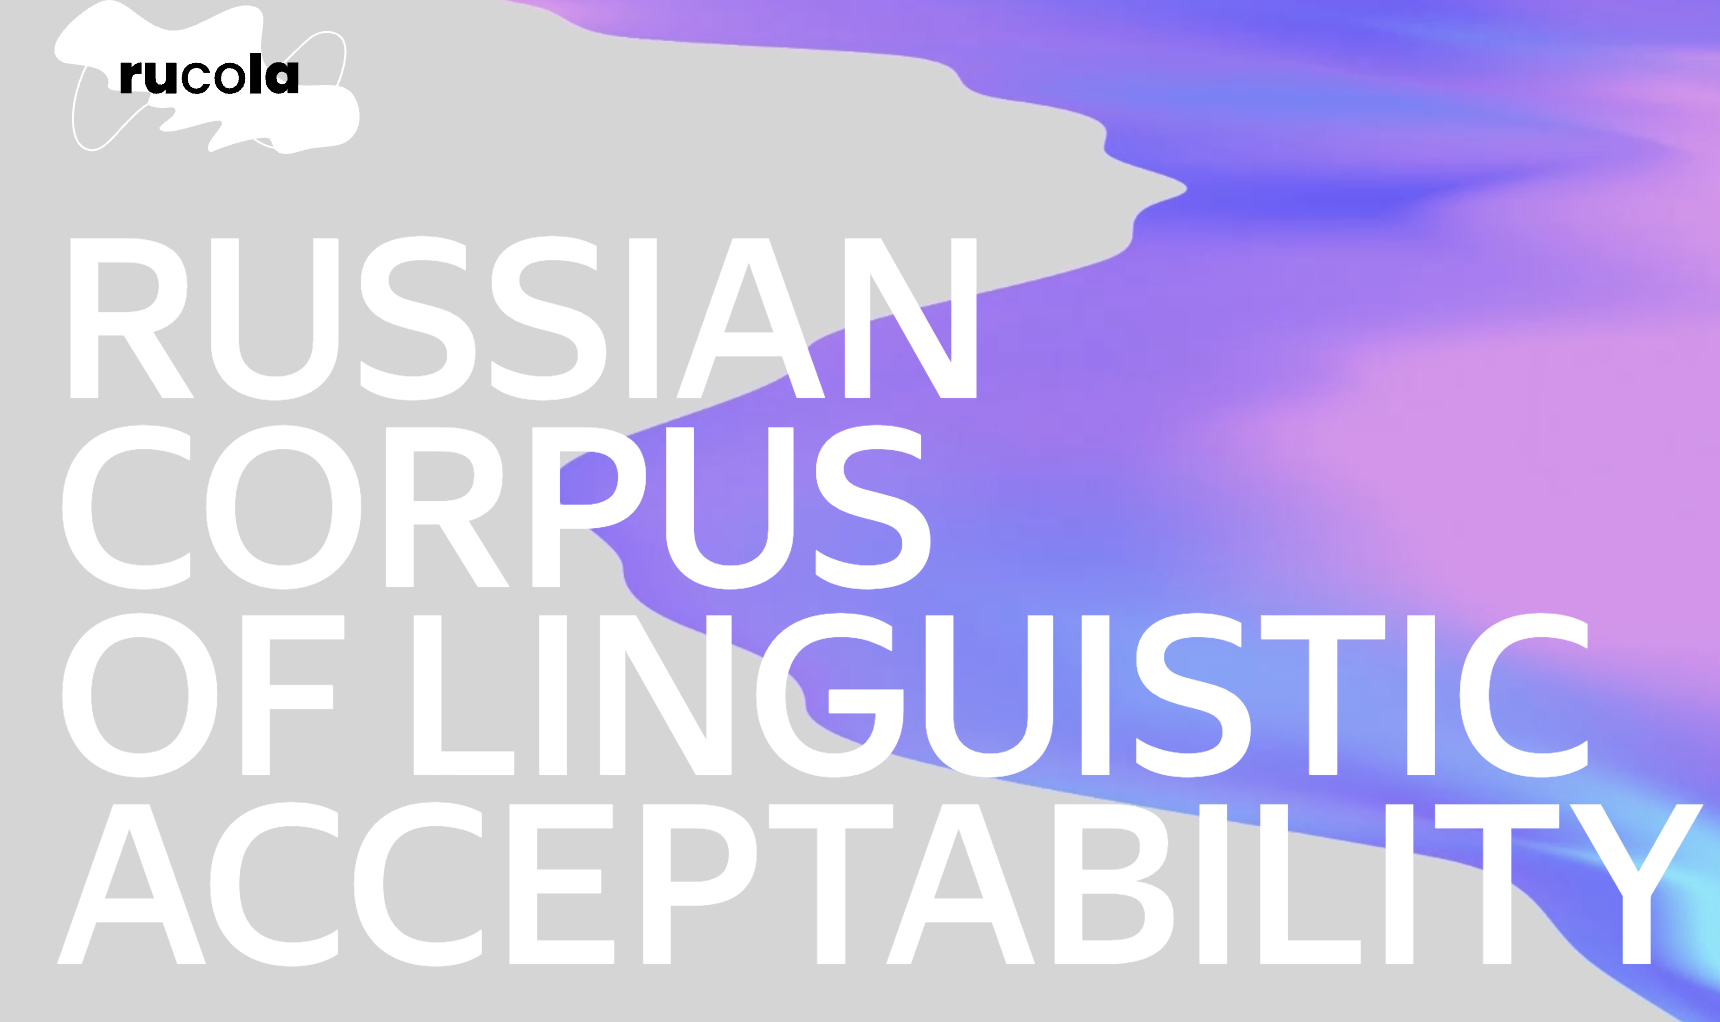

### <a id="data-analysis"></a>[7%] 1. Data analysis 

* 1.1  (5%) [Download](https://github.com/RussianNLP/RuCoLA/tree/main/data) the data(you need only `in_domain_train.csv` for training and  `in_domain_dev.csv` for the evaluation) and calculate basic statistics (example number, class distribution, mean sentence length, number of unique words, etc.) and make visualizations, if necessary.

In [9]:
data = pd.read_csv('https://raw.githubusercontent.com/RussianNLP/RuCoLA/main/data/in_domain_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/RussianNLP/RuCoLA/main/data/in_domain_dev.csv')

In [10]:
# Number of training sentences
data.shape

(7869, 5)

In [11]:
# Show 10 random training sentences
data.iloc[sorted(np.random.choice(data.shape[0], 10, replace=False))]

,id,sentence,acceptable,error_type,detailed_source
121,121,"Даже неточное, строго говоря, упоминание про п...",1,0,Seliverstova
2176,2176,"Он не раз упрекал меня за то, что я не имею да...",1,0,Paducheva2013
4509,4509,"Боюсь, как бы он не обиделся.",1,0,Rusgram
4999,4999,"Чтобы не попасть кому-нибудь на обед, некоторы...",0,Syntax,USE8
5128,5128,Он не в Париже.,1,0,Paducheva2013
5714,5714,День на день не приходится: примерно двумя тыс...,0,Morphology,USE7
6977,6977,Среди его учеников есть талантливые.,1,0,Paducheva2013
7305,7305,Елена на днях застала меня целующим руки у Зои!,1,0,Paducheva2004
7401,7401,"Это то впечатление, которое вы хотите того, чт...",0,Syntax,Lutikova
7750,7750,Сегодня отца еще не было на море.,0,Semantics,Paducheva2013


In [12]:
# Examine target
target = 'acceptable'

In [13]:
# check nulls
data[target].isna().sum()

0

In [14]:
# Target distribution
data[target].value_counts(normalize=True)

acceptable
1    0.745203
0    0.254797
Name: proportion, dtype: float64

In [15]:
_ = pd.DataFrame(data[target].value_counts(ascending=True)).reset_index()
_

,acceptable,count
0,0,2005
1,1,5864


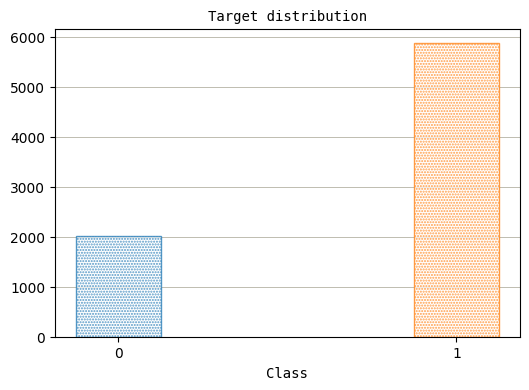

In [16]:
plot_bar(_, target, 'count', 'Class', 'Target distribution')

In [17]:
# Positive to negative classes imbalance ratio
_.iloc[1]['count'] / _.iloc[0]['count']

2.9246882793017455

In [18]:
# Mean sentence length in characters
data['sentence'].apply(len).mean()

54.973058838480114

In [19]:
# Mean sentence length in words, if split by whitespaces
data['sentence'].str.split().apply(len).mean()

8.55648748252637

In [46]:
# All words (bag of words)
bow = data['sentence'].str.replace('.', ' ').sum().split()
# Show 10 random words
np.array(bow)[np.random.choice(len(bow), 10, replace=False)]

array(['Камень', 'обнаружил', 'подарок', 'и', 'утомлением', 'переводить',
       'несмотря', 'стало', 'альпинизм', 'уважения'], dtype='<U31')

In [21]:
# Number of unique words
len(set(bow))

21254

In [22]:
# Top-10 most common words
Counter(bow).most_common(10)

[('не', 1762),
 ('в', 1596),
 ('и', 1410),
 ('на', 1029),
 ('что', 813),
 ('Я', 700),
 ('Он', 627),
 ('с', 622),
 ('он', 528),
 ('я', 473)]

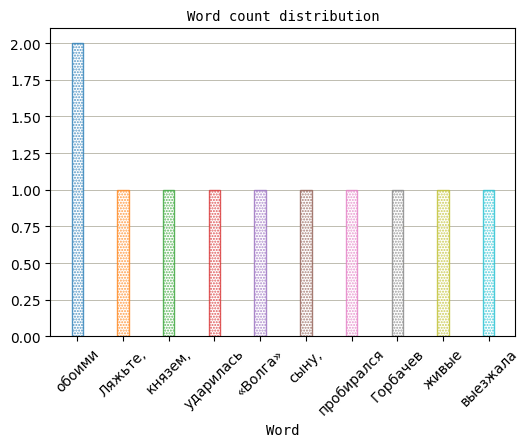

In [23]:
# Count distribution of 10 random words
_ = pd.DataFrame(Counter(bow).items()).iloc[np.random.choice(len(Counter(bow)), 10)].sort_values(by=1, ascending=False)
plot_bar(_, 0, 1, 'Word', 'Word count distribution', rot=45)

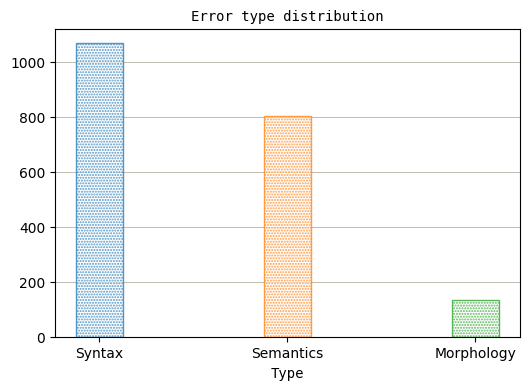

In [24]:
# Error type distribution
_ = pd.DataFrame(data[data['error_type'] != '0']['error_type'].value_counts(ascending=False)).reset_index()
plot_bar(_, 'error_type', 'count', 'Type', 'Error type distribution')

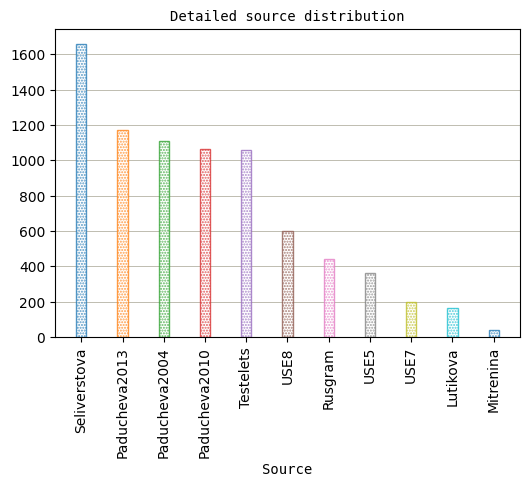

In [25]:
# Detailed source distribution
_ = pd.DataFrame(data['detailed_source'].value_counts(ascending=False)).reset_index()
plot_bar(_, 'detailed_source', 'count', 'Source', 'Detailed source distribution', rot=90)

* 1.2.  (2%) Split the data from `in_domain_train.csv` into train and val (`val_size = 10%`). Do not forget to fix `random_state` for reproducibility.

In [48]:
#train, val = train_test_split(data, test_size=0.1, stratify=data[target], random_state=seed)
train, val = torch.utils.data.random_split(data, lengths=[0.9, 0.1])

In [56]:
len(val.indices)

786

In [ ]:
# Checks split
# (
#     np.allclose(train.shape[0] / data.shape[0], 0.9, atol=1e-4), # Train 90%
#     np.allclose(val.shape[0] / data.shape[0], 0.1, atol=1e-4), # Validation 10%
# )

In [58]:
#train[target].value_counts(normalize=True)

In [59]:
#val[target].value_counts(normalize=True)

### <a id="rubert"></a>[10%] 2. Fine-tune RuBERT

* 2.0 Study the [tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) on BERT model fine-tuning.

**Note:** this part is not graded. However, you may find the material from the tutorial useful  for the successful task completion.

* 2.1 Take RuBert model (BERT for the Russian language). You may use any other BERT-like models for the Russian language from [Hugging Face](https://huggingface.co/) project. For example, you may use [`sberbank-ai/ruBert-base`](https://huggingface.co/sberbank-ai/ruBert-base) or [`DeepPavlov/rubert-base-cased`](https://huggingface.co/DeepPavlov/rubert-base-cased).

First, let's create a model factory, which builds a new model based on some pre-trained one, but with the untrained last classification layer. We will use it for all BERT models. We will also train and validate our models with this factory.

In [ ]:
class RucolaClassifier:
    def __init__(self, base_model:str, verbose=False):
        # 1. Create an existing pre-trained model
        if base_model not in ('rubert', 'mbert'):
            raise ValueError("base_model should be one of 'rubert', 'mbert'")
        if base_model == 'rubert':
            # https://huggingface.co/ai-forever/ruBert-base
            self.name = 'rubert'
            self.model = BertForSequenceClassification.from_pretrained('ruBert-base', num_labels = 2, output_attentions = False, output_hidden_states = False)
            self.tokenizer = BertTokenizer.from_pretrained('ruBert-base')
        else: # base_model == 'mbert'
            # https://huggingface.co/bert-base-multilingual-cased
            self.name = 'mbert'
            self.model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels = 2, output_attentions = False, output_hidden_states = False)
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        # 2. Freeze all layers
        #for param in self.model.parameters():
         #   param.requires_grad = False
        # 3. Replace the last layer (1000 ImageNet classes) with a new untrained layer (101 Food classes)
        #out_features = 101
        #if base_model == 'vit':
         #   in_features = self.model.classifier.in_features
          #  self.model.classifier = torch.nn.Linear(in_features, out_features)
        #else: # base_model ~ 'resnet'
         #   in_features = self.model.fc.in_features
          #  self.model.fc = torch.nn.Linear(in_features, out_features)
        self.is_trained = False
        self.verbose = verbose
        self.model = self.model.to(device)

    def train(self, train_subset, val_subset, optimizer, epochs:int):
        # 1. Apply transform to `train_subset`. Note: this will change the actual parent dataset's transform, so 1) copy first, 2) no need to transform `val_subset`.
        #_train_transform = train_subset.dataset.transform
        #train_subset.dataset.transform = self.transform
        # 2. Create data loaders
        self.train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        self.val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        # 3. Store loss function and optimizer
        #self.criterion = criterion
        self.optimizer = optimizer
        # 4. Do train and eval loop for the number of epochs
        self.train_losses, self.val_losses, self.train_accs, self.val_accs = [], [], [], []
        for epoch_i, _ in enumerate(range(epochs), start=1):
            print(f'-------------\nEpoch: {epoch_i:>2}/{epochs}')
            # Train one epoch
            self._train()
            # Eval one epoch
            self._validate()
        # 5. Restore transform
        #train_subset.dataset.transform = _train_transform
    
    def _train(self):
        '''
        Train the classifier on all batches of the `train_loader` for one epoch.
        '''
        # 1. Switch to train mode
        self.model.train()

        # 2. Do train loop for all batches for one epoch
        print('\nTraining...')
        losses, accs = [], []
        n_batches_to_show = np.ceil(len(self.train_loader) / 10)
        for i, data in tqdm(enumerate(self.train_loader), total=len(self.train_loader)):
            #inputs, labels = data
            #inputs, labels = inputs.to(device), labels.to(device)
            input_ids = data[0].to(device)
            input_mask = data[1].to(device)
            labels = data[2].to(device)
            self.optimizer.zero_grad()
            #outputs = self.model(inputs)
            #loss = self.criterion(outputs, labels)
            loss, logits = self.model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            losses.append(loss.item())
            acc = torch.mean(logits.argmax(axis=1) == labels, dtype=float)
            accs.append(acc.item())
            if self.verbose:
                if i % n_batches_to_show == 0:
                    print(f'Batch: {i:>4}, Train loss: {loss:.2f}, Train accuracy: {acc:.2f}')
        # 3. Keep and report train metrics for one epoch
        epoch_mean_loss = np.mean(losses)
        self.train_losses.append(epoch_mean_loss)
        epoch_mean_acc = np.mean(accs)
        self.train_accs.append(np.mean(epoch_mean_acc))
        print(f'Epoch avg: Train loss: {epoch_mean_loss:.2f}, Train accuracy: {epoch_mean_acc:.2f}')

    def _validate(self):
        '''
        Validate the classifier on all batches of the `val_loader` for one epoch.
        '''
        # 1. Switch to eval mode
        self.model.eval()

        # 2. Do eval loop
        print('\nEvaluating...')
        losses, accs = [], []
        n_batches_to_show = np.ceil(len(self.val_loader) / 10)
        with torch.no_grad():
            for i, data in tqdm(enumerate(self.val_loader), total=len(self.val_loader)):
                #inputs, labels = data
                #inputs, labels = inputs.to(device), labels.to(device)
                input_ids = data[0].to(device)
                input_mask = data[1].to(device)
                labels = data[2].to(device)
                #outputs = self.model(inputs)
                #loss = self.criterion(outputs, labels)
                loss, logits = self.model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
                losses.append(loss.item())
                acc = torch.mean(logits.argmax(axis=1) == labels, dtype=float)
                accs.append(acc.item())
                if self.verbose:
                    if i % n_batches_to_show == 0:
                        print(f'Batch: {i:>3}, Val loss: {loss:.2f}, Val accuracy: {acc:.2f}')
        # 3. Keep and report val metrics for one epoch
        epoch_mean_loss = np.mean(losses)
        self.val_losses.append(epoch_mean_loss)
        epoch_mean_acc = np.mean(accs)
        self.val_accs.append(np.mean(epoch_mean_acc))
        print(f'Epoch avg: Val loss: {epoch_mean_loss:.2f}, Val accuracy: {epoch_mean_acc:.2f}')

* 2.2   (5%) Fine-tune RuBERT on RuCoLa train part created in 1.2. Do not forget about validation in process of training on val set created in 1.2. Select optimal epochs number, using the statistics on the val set.

* 2.3  (5%) Evaluate your fine-tuned model (use accuracy and MCC metrics and `in_domain_dev.csv` for the evaluation), analyze the results and make conclusions.

### <a id="mbert-1"></a>[10%] 3. Fine-tune mBERT on RuCoLa

* 3.1 Now take a multilingual BERT model (BERT for the Russian language), or simply [mBERT](https://huggingface.co/bert-base-multilingual-cased) from [Hugging Face](https://huggingface.co/) project. 

* 3.2   (5%) Similarly to 2, fine-tune mBERT on RuCoLa train part created in 1.2. Do not forget about validation in process of training on val set created in 1.2. Select optimal epochs number, using the statistics on the val set.

* 3.3  (5%) Evaluate your fine-tuned model (use accuracy and MCC metrics and `in_domain_dev.csv` for the evaluation), analyze the results and make conclusions.

### <a id="mbert-2"></a>[13%] 4. Fine-tune mBERT on RuCoLa + CoLa

* 4.1 (3%) Augment the training data with English examples from [CoLa](https://nyu-mll.github.io/CoLA/) dataset, which is the English analogue of RuCoLa (you probably know it if you studies the tutorial in 2.0). You need `in_domain_train.tsv` which can be found [here](https://github.com/nyu-mll/CoLA-baselines/tree/master/acceptability_corpus/cola_public/raw).

* 4.2   (5%) Similarly to 3, fine-tune mBERT from 2.1 on RuCoLa train part created in 1.2 + `in_domain_train.tsv` from CoLa dataset. Do not forget about validation in process of training on val set created in 1.2. Select optimal epochs number, using the statistics on the val set.

* 4.3  (5%) Evaluate your fine-tuned model (use accuracy and MCC metrics and `in_domain_dev.csv` for the evaluation), analyze the results and make conclusions.

### [10%] 5. Summary & results analysis

* 5.1    (5%) Compare the results of the all the tested models. First, compare them between each other, then with other models on [RuCoLa leaderboard](https://rucola-benchmark.com/leaderboard). Do not forget to mention, how the English data influences mBERT results.

* 5.2    (5%) Propose, how you may improve the model score (write at least three ideas).

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text).
* Make sure that the instructor can run all the cells to reproduce your results.
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques.
* Provide links to the tutorials you use for reference.